# Super Resolution

<div class="alert alert-info">

This tutorial is available as an IPython notebook at [malaya-speech/example/super-resolution](https://github.com/huseinzol05/malaya-speech/tree/master/example/super-resolution).
    
</div>

<div class="alert alert-info">

This module is language independent, so it save to use on different languages. Pretrained models trained on multilanguages.
    
</div>

<div class="alert alert-warning">

This is an application of malaya-speech Pipeline, read more about malaya-speech Pipeline at [malaya-speech/example/pipeline](https://github.com/huseinzol05/malaya-speech/tree/master/example/pipeline).
    
</div>

### Dataset

Trained on English, Manglish and Bahasa podcasts with augmented noises, gathered at https://github.com/huseinzol05/malaya-speech/tree/master/data/podcast

Purpose of this module to increase sample rate.

In [1]:
import malaya_speech
import numpy as np
from malaya_speech import Pipeline
import IPython.display as ipd

### List available deep model

In [2]:
malaya_speech.super_resolution.available_model()

INFO:root:Only calculate SDR, ISR, SAR on voice sample. Higher is better.


Size (MB)  Quantized Size (MB)       SDR        ISR        SAR
srgan-128       7.37                 2.04  17.03345  22.330260  17.454372
srgan-256      29.50                 7.55  16.34558  22.067493  17.024390

We modified SRGAN to do 1D Convolution and use output distance as generator loss, originally use content loss.

### Load deep model

```python
def deep_model(model: str = 'srgan-256', quantized: bool = False, **kwargs):
    """
    Load Super Resolution 4x deep learning model.

    Parameters
    ----------
    model : str, optional (default='srgan-256')
        Model architecture supported. Allowed values:

        * ``'srgan-128'`` - srgan with 128 filter size and 16 residual blocks.
        * ``'srgan-256'`` - srgan with 256 filter size and 16 residual blocks.
    quantized : bool, optional (default=False)
        if True, will load 8-bit quantized model. 
        Quantized model not necessary faster, totally depends on the machine.

    Returns
    -------
    result : malaya_speech.model.tf.UNET1D class
    """
```

In [3]:
model = malaya_speech.super_resolution.deep_model(model = 'srgan-256')
model_128 = malaya_speech.super_resolution.deep_model(model = 'srgan-128')


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


### Load Quantized deep model

To load 8-bit quantized model, simply pass `quantized = True`, default is `False`.

We can expect slightly accuracy drop from quantized model, and not necessary faster than normal 32-bit float model, totally depends on machine.

In [4]:
quantized_model = malaya_speech.super_resolution.deep_model(model = 'srgan-256', quantized = True)
quantized_model_128 = malaya_speech.super_resolution.deep_model(model = 'srgan-128', quantized = True)

### Important factor

1. Currently we only supported 4x super resolution, if input sample rate is 16k, output will become 16k * 4.
2. We trained on 11025 for input sample rate, 44100 for output sample rate.

### Predict

```python
def predict(self, input):
    """
    Enhance inputs, will return waveform.

    Parameters
    ----------
    input: np.array
        np.array or malaya_speech.model.frame.Frame.

    Returns
    -------
    result: np.array
    """
```

Let say we have a low sample rate audio,

In [5]:
sr = 44100
reduction_factor = 4

In [6]:
y, sr_ = malaya_speech.load('speech/44k/test-0.wav', sr = sr // reduction_factor)
ipd.Audio(y[:sr_ * 4], rate = sr_)

In [7]:
%%time

output = model(y)
ipd.Audio(output[:sr * 4], rate = sr)

CPU times: user 1min 2s, sys: 3.49 s, total: 1min 5s
Wall time: 10.9 s


In [8]:
%%time

output = model_128(y)
ipd.Audio(output[:sr * 4], rate = sr)

CPU times: user 18.1 s, sys: 1.74 s, total: 19.8 s
Wall time: 3.54 s


In [9]:
%%time

output = quantized_model_128(y)
ipd.Audio(output[:sr * 4], rate = sr)

CPU times: user 18.2 s, sys: 2.05 s, total: 20.2 s
Wall time: 3.89 s


Below is common technique people do upsampling using interpolate,

In [10]:
y_ = malaya_speech.resample(y, sr // reduction_factor, sr)
ipd.Audio(y_[:sr * 4], rate = sr)

### Try more examples

In [11]:
y, sr_ = malaya_speech.load('speech/example-speaker/husein-generated.wav', sr = sr // reduction_factor)
sr_

11025

In [12]:
ipd.Audio(y[:sr_ * 4], rate = sr_)

In [13]:
%%time

output = model(y)
ipd.Audio(output[:sr * 4], rate = sr)

CPU times: user 58.1 s, sys: 3.38 s, total: 1min 1s
Wall time: 10.5 s


In [14]:
%%time

output = model_128(y)
ipd.Audio(output[:sr * 4], rate = sr)

CPU times: user 17.2 s, sys: 1.6 s, total: 18.8 s
Wall time: 3.14 s


In [15]:
y_ = malaya_speech.resample(y, sr_, sr)
ipd.Audio(y_[:sr * 4], rate = sr)

In [16]:
y, sr_ = malaya_speech.load('speech/44k/test-2.wav', sr = sr // reduction_factor)
ipd.Audio(y[:sr_ * 4], rate = sr_)

In [17]:
%%time

output = model(y)
ipd.Audio(output[:sr * 4], rate = sr)

CPU times: user 1min 1s, sys: 3.64 s, total: 1min 4s
Wall time: 11.5 s


In [18]:
%%time

output = model_128(y)
ipd.Audio(output[:sr * 4], rate = sr)

CPU times: user 18.5 s, sys: 1.83 s, total: 20.3 s
Wall time: 3.72 s


In [19]:
y_ = malaya_speech.resample(y, sr_, sr)
ipd.Audio(y_[:sr * 4], rate = sr)

### Use Pipeline

Incase your audio is too long and you do not want to burden your machine. So, you can use malaya-speech Pipeline to split the audio splitted to 3 seconds, predict one-by-one and combine after that.

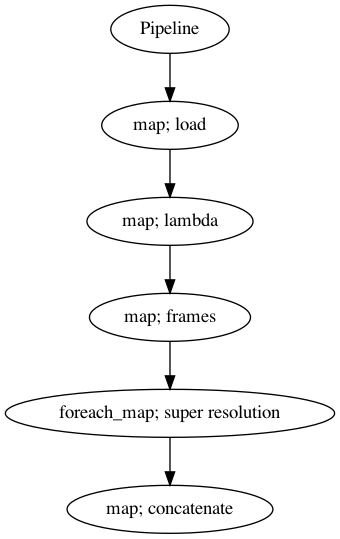

In [20]:
p = Pipeline()
pipeline = (
    p.map(malaya_speech.load, sr = sr // reduction_factor)
    .map(lambda x: x[0])
    .map(malaya_speech.generator.frames, frame_duration_ms = 3000, sample_rate = sr // reduction_factor)
    .foreach_map(model_128)
    .map(np.concatenate)
)
p.visualize()

In [21]:
%%time

results = p('speech/podcast/nusantara.wav')

CPU times: user 20.2 s, sys: 2.52 s, total: 22.7 s
Wall time: 4.19 s


In [22]:
results.keys()

dict_keys(['load', '<lambda>', 'frames', 'super-resolution', 'concatenate'])

In [23]:
ipd.Audio(results['concatenate'], rate = sr)

In [24]:
ipd.Audio(results['<lambda>'], rate = sr // reduction_factor)

In [25]:
y_ = malaya_speech.resample(results['<lambda>'], sr // reduction_factor, sr)
ipd.Audio(y_, rate = sr)